In [98]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path

In [133]:
# Quick header check (run this cell whenever you want to inspect a file)
check_file = "2w67 0.csv"   # <- change this
df_check = pd.read_csv(check_file)
print("\nFILE:", check_file)
print(df_check.head())



FILE: 2w67 20.csv
          Time   Channel A   Channel B   Channel C   Channel D
0          (s)         (V)         (V)         (V)        (mV)
1  -1.00000381  0.33082060  0.20661030  0.20441300  0.24903100
2  -1.00000159  0.33112590  0.20667130  0.20453510  0.24842070
3  -0.99999937  0.33143100  0.20685450  0.20465710  0.25025180
4  -0.99999714  0.33173620  0.20697650  0.20477920  0.25269320


C:\Users\james\AppData\Local\Temp\ipykernel_17608\309652652.py:3: DtypeWarning: Columns (0,1,2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_check = pd.read_csv(check_file)


In [174]:
# =========================
# 0) FILE CHOICE (MOVE UP)
# =========================
file = "2w67 60 ac.csv"  # <-- change this

# Choose ONE VI conversion function:
# vi_func = VI_from_ABCD
# vi_func = VI_from_ABCD_bigD
# vi_func = VI_from_ABCD_bigR_lowD
# vi_func = VI_from_ABC
# (Definitions are below; pick here, then scroll no more.)
vi_func_name = "VI_from_ABCD"  # <-- change this string to match your choice


# =========================
# 1) OUTPUT SETTINGS
# =========================
output_folder = "w67 RT 77 PVCR test 2"
out_dir = Path(output_folder)
out_dir.mkdir(parents=True, exist_ok=True)


In [175]:
# =========================
# 2) WINDOW SETTINGS
# =========================
dv_after_peak = 0.02  # V: ignore points within this voltage of the peak when searching for the valley

# +V side
Vpeak_pos_min, Vpeak_pos_max = 0.2, 0.4
Vval_pos_min,  Vval_pos_max  = 0.2, 0.55

# -V side
Vpeak_neg_min, Vpeak_neg_max = -0.4, -0.2
Vval_neg_min,  Vval_neg_max  = -0.55, -0.2

# Optional per-file window overrides (usually leave empty)
wins = {}

In [176]:
# =========================
# 3) CONVERSION FUNCTIONS
# =========================
def VI_from_ABCD(df, R_series=3256):
    A = pd.to_numeric(df["Channel A"], errors="coerce")
    B = pd.to_numeric(df["Channel B"], errors="coerce")
    C = pd.to_numeric(df["Channel C"], errors="coerce")
    D = pd.to_numeric(df["Channel D"], errors="coerce")
    V = C - D / 1000
    I = (A - B) / R_series
    return V, I

def VI_from_ABCD_bigD(df, R_series=216.6):
    A = pd.to_numeric(df["Channel A"], errors="coerce")
    B = pd.to_numeric(df["Channel B"], errors="coerce")
    C = pd.to_numeric(df["Channel C"], errors="coerce")
    D = pd.to_numeric(df["Channel D"], errors="coerce")
    V = C - D
    I = (A - B) / R_series
    return V, I

def VI_from_ABCD_bigR_lowD(df, R_series=98.2):
    A = pd.to_numeric(df["Channel A"], errors="coerce")
    B = pd.to_numeric(df["Channel B"], errors="coerce")
    C = pd.to_numeric(df["Channel C"], errors="coerce")
    D = pd.to_numeric(df["Channel D"], errors="coerce")
    V = C - D / 1000
    I = (A - B) / R_series
    return V, I

def VI_from_ABC(df, R_series=98):
    A = pd.to_numeric(df["Channel A"], errors="coerce")
    B = pd.to_numeric(df["Channel B"], errors="coerce")
    C = pd.to_numeric(df["Channel C"], errors="coerce")
    # EDIT THESE to match your A,B,C-only wiring/units:
    V = C - B
    I = A / R_series
    return V, I

# Map the string choice to the actual function (so selection stays at the top)
VI_FUNCS = {
    "VI_from_ABCD": VI_from_ABCD,
    "VI_from_ABCD_bigD": VI_from_ABCD_bigD,
    "VI_from_ABCD_bigR_lowD": VI_from_ABCD_bigR_lowD,
    "VI_from_ABC": VI_from_ABC,
}
if vi_func_name not in VI_FUNCS:
    raise ValueError(f"Unknown vi_func_name='{vi_func_name}'. Choose one of: {list(VI_FUNCS.keys())}")
vi_func = VI_FUNCS[vi_func_name]

In [177]:
# =========================
# 4) HELPERS
# =========================
def centreline_by_voltage_bins(V, I, vmin, vmax, bin_width=0.002, stat="median", min_pts=20):
    """
    Build a robust centreline I(V) by binning in V and summarising I in each bin.
    This is designed to pick the 'middle of the thick trace' at low temperature.
    """
    finite = np.isfinite(V) & np.isfinite(I)
    V = V[finite]
    I = I[finite]
    if V.size == 0:
        return np.array([]), np.array([])

    # Bin edges
    edges = np.arange(vmin, vmax + bin_width, bin_width)
    if edges.size < 3:
        return np.array([]), np.array([])

    Vc, Ic = [], []
    for lo, hi in zip(edges[:-1], edges[1:]):
        m = (V >= lo) & (V < hi)
        if m.sum() < min_pts:
            continue

        ii = I[m]
        if stat == "median":
            ic = np.median(ii)
        elif stat == "mean":
            ic = np.mean(ii)
        elif stat == "trimmed_mean":
            q1, q2 = np.quantile(ii, [0.2, 0.8])
            core = ii[(ii >= q1) & (ii <= q2)]
            ic = np.mean(core) if core.size else np.mean(ii)
        else:
            raise ValueError("stat must be 'median', 'mean', or 'trimmed_mean'")

        Vc.append(0.5 * (lo + hi))
        Ic.append(ic)

    return np.array(Vc, dtype=float), np.array(Ic, dtype=float)


def _peak_valley_side(
    V, I,
    Vpeak_min, Vpeak_max,
    Vval_min, Vval_max,
    side="+",
    dv_after_peak=0.0,
    use_centreline=False,
    bin_width=0.002,
    stat="median",
    min_pts=20
):
    finite = np.isfinite(V) & np.isfinite(I)
    V = V[finite]
    I = I[finite]

    out = {
        "V_peak": np.nan, "I_peak": np.nan,
        "V_valley": np.nan, "I_valley": np.nan,
        # optional, for plotting/debug
        "V_peak_curve": np.array([]), "I_peak_curve": np.array([]),
        "V_val_curve":  np.array([]), "I_val_curve":  np.array([]),
    }
    if V.size < 10:
        return out

    # Peak in window
    mask_peak = (V >= Vpeak_min) & (V <= Vpeak_max)
    if mask_peak.sum() < 10:
        return out

    Vp_raw = V[mask_peak]
    Ip_raw = I[mask_peak]

    if use_centreline:
        Vp, Ip = centreline_by_voltage_bins(
            Vp_raw, Ip_raw,
            vmin=Vpeak_min, vmax=Vpeak_max,
            bin_width=bin_width, stat=stat, min_pts=min_pts
        )
        out["V_peak_curve"], out["I_peak_curve"] = Vp, Ip
        if Vp.size < 5:
            return out
    else:
        Vp, Ip = Vp_raw, Ip_raw

    idx_peak = np.argmax(Ip) if side == "+" else np.argmin(Ip)
    V_peak = float(Vp[idx_peak])
    I_peak = float(Ip[idx_peak])
    out["V_peak"], out["I_peak"] = V_peak, I_peak

    # Valley: enforce post-peak by voltage (prevents wrong valley pick)
    if side == "+":
        v_start = max(Vval_min, V_peak + dv_after_peak)
        mask_val = (V >= v_start) & (V <= Vval_max)
        if mask_val.sum() < 10:
            return out

        Vv_raw = V[mask_val]
        Iv_raw = I[mask_val]

        if use_centreline:
            Vv, Iv = centreline_by_voltage_bins(
                Vv_raw, Iv_raw,
                vmin=v_start, vmax=Vval_max,
                bin_width=bin_width, stat=stat, min_pts=min_pts
            )
            out["V_val_curve"], out["I_val_curve"] = Vv, Iv
            if Vv.size < 5:
                return out
        else:
            Vv, Iv = Vv_raw, Iv_raw

        idx_val = np.argmin(Iv)

    else:
        v_end = min(Vval_max, V_peak - dv_after_peak)
        mask_val = (V <= v_end) & (V >= Vval_min)
        if mask_val.sum() < 10:
            return out

        Vv_raw = V[mask_val]
        Iv_raw = I[mask_val]

        if use_centreline:
            Vv, Iv = centreline_by_voltage_bins(
                Vv_raw, Iv_raw,
                vmin=Vval_min, vmax=v_end,
                bin_width=bin_width, stat=stat, min_pts=min_pts
            )
            out["V_val_curve"], out["I_val_curve"] = Vv, Iv
            if Vv.size < 5:
                return out
        else:
            Vv, Iv = Vv_raw, Iv_raw

        idx_val = np.argmax(Iv)

    out["V_valley"] = float(Vv[idx_val])
    out["I_valley"] = float(Iv[idx_val])
    return out


def current_at_V0(V, I):
    finite = np.isfinite(V) & np.isfinite(I)
    V = V[finite]
    I = I[finite]
    if V.size == 0:
        return np.nan, np.nan, "none"

    # Interpolate if straddling V=0
    neg = np.where(V < 0)[0]
    pos = np.where(V > 0)[0]
    if neg.size > 0 and pos.size > 0:
        i1 = neg[np.argmax(V[neg])]
        i2 = pos[np.argmin(V[pos])]
        V1, V2 = V[i1], V[i2]
        I1, I2 = I[i1], I[i2]
        if V2 != V1:
            I0 = I1 + (0 - V1) * (I2 - I1) / (V2 - V1)
            return float(I0), 0.0, "interp"

    # Otherwise nearest point
    j = np.argmin(np.abs(V))
    return float(I[j]), float(V[j]), "nearest"


--- 2w67 60 ac ---
+ side peak:   V=0.371 V, I=0.00202350095 A
+ side valley: V=0.508 V, I=0.000215982064 A
+ PVCR(offset): 8.876
- side peak:   V=-0.343 V, I=-0.00194404592 A
- side valley: V=-0.467 V, I=-0.000199673219 A
- PVCR(offset): 10.370

I(V=0):        I=-1.35048821e-05 A  (method=interp, V_used=0 V)

Saved raw output: w67 RT 77 PVCR test 2\2w67 60 ac_raw_output.txt
Saved summary: w67 RT 77 PVCR test 2\peak_valley_offset_summary_single.csv


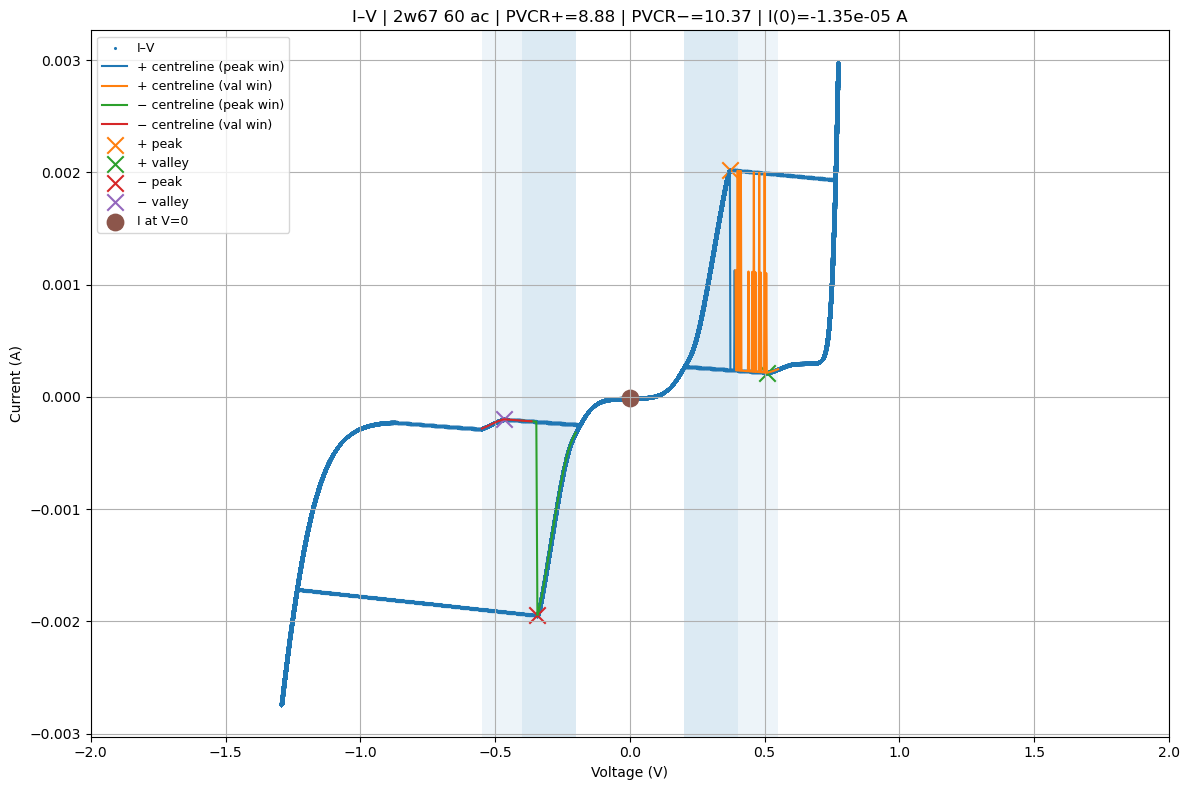

Saved: w67 RT 77 PVCR test 2\2w67 60 ac_IV_peak_valley_offset.png


In [178]:
# =========================
# 5) MAIN
# =========================
def main():
    base = Path(file).stem

    # --- centreline controls (good defaults for 4.2 K) ---
    use_centreline = True       # <-- set False for room-temp / cleaner traces
    bin_width = 0.002           # volts (2 mV). Try 0.005 if still noisy
    stat = "median"             # "median" recommended; can try "trimmed_mean"
    min_pts = 20                # reduce if your data is sparse

    plot_centreline = True      # overlay the centreline used for picking

    # Apply per-file windows if provided
    Vp1, Vp2 = wins.get("Vpeak_pos", (Vpeak_pos_min, Vpeak_pos_max))
    Vv1, Vv2 = wins.get("Vval_pos",  (Vval_pos_min,  Vval_pos_max))
    Vn1, Vn2 = wins.get("Vpeak_neg", (Vpeak_neg_min, Vpeak_neg_max))
    Vnv1, Vnv2 = wins.get("Vval_neg", (Vval_neg_min,  Vval_neg_max))

    print(f"\n--- {base} ---")

    df = pd.read_csv(file, low_memory=False)
    V_s, I_s = vi_func(df)
    V = np.asarray(V_s, dtype=float)
    I = np.asarray(I_s, dtype=float)

    # Offset at V=0
    I0, V0_used, method0 = current_at_V0(V, I)

    # Peak/valley (now optionally using centreline)
    pos = _peak_valley_side(
        V, I, Vp1, Vp2, Vv1, Vv2,
        side="+", dv_after_peak=dv_after_peak,
        use_centreline=use_centreline, bin_width=bin_width, stat=stat, min_pts=min_pts
    )
    neg = _peak_valley_side(
        V, I, Vn1, Vn2, Vnv1, Vnv2,
        side="-", dv_after_peak=dv_after_peak,
        use_centreline=use_centreline, bin_width=bin_width, stat=stat, min_pts=min_pts
    )

    # PVCR with offset correction (NO modulus)
    PVCR_pos = np.nan
    if np.isfinite(pos["I_peak"]) and np.isfinite(pos["I_valley"]) and np.isfinite(I0):
        denom = (pos["I_valley"] - I0)
        PVCR_pos = np.inf if denom == 0 else (pos["I_peak"] - I0) / denom

    PVCR_neg = np.nan
    if np.isfinite(neg["I_peak"]) and np.isfinite(neg["I_valley"]) and np.isfinite(I0):
        denom = (neg["I_valley"] - I0)
        PVCR_neg = np.inf if denom == 0 else (neg["I_peak"] - I0) / denom

    # ---- Nice “one column” output only ----
    if np.isfinite(pos["V_peak"]):
        print(f"+ side peak:   V={pos['V_peak']:.3f} V, I={pos['I_peak']:.9g} A")
    else:
        print("+ side peak:   not found")

    if np.isfinite(pos["V_valley"]):
        print(f"+ side valley: V={pos['V_valley']:.3f} V, I={pos['I_valley']:.9g} A")
    else:
        print("+ side valley: not found")

    print(f"+ PVCR(offset): {PVCR_pos:.3f}")

    if np.isfinite(neg["V_peak"]):
        print(f"- side peak:   V={neg['V_peak']:.3f} V, I={neg['I_peak']:.9g} A")
    else:
        print("- side peak:   not found")

    if np.isfinite(neg["V_valley"]):
        print(f"- side valley: V={neg['V_valley']:.3f} V, I={neg['I_valley']:.9g} A")
    else:
        print("- side valley: not found")

    print(f"- PVCR(offset): {PVCR_neg:.3f}")
    print(f"\nI(V=0):        I={I0:.9g} A  (method={method0}, V_used={V0_used:g} V)\n")

    # ---------- SAVE THE "RAW" CONSOLE BLOCK ABOVE THE GRAPH ----------
    raw_lines = [
        f"--- {base} ---",
        f"+ side peak:   V={pos['V_peak']:.6g} V, I={pos['I_peak']:.12g} A" if np.isfinite(pos["V_peak"]) else "+ side peak:   not found",
        f"+ side valley: V={pos['V_valley']:.6g} V, I={pos['I_valley']:.12g} A" if np.isfinite(pos["V_valley"]) else "+ side valley: not found",
        f"+ PVCR(offset): {PVCR_pos:.6g}",
        f"- side peak:   V={neg['V_peak']:.6g} V, I={neg['I_peak']:.12g} A" if np.isfinite(neg["V_peak"]) else "- side peak:   not found",
        f"- side valley: V={neg['V_valley']:.6g} V, I={neg['I_valley']:.12g} A" if np.isfinite(neg["V_valley"]) else "- side valley: not found",
        f"- PVCR(offset): {PVCR_neg:.6g}",
        f"I(V=0):        I={I0:.12g} A  (method={method0}, V_used={V0_used:.6g} V)",
        f"centreline:    use={use_centreline}, bin_width={bin_width:g} V, stat={stat}, min_pts={min_pts}",
    ]
    raw_txt = "\n".join(raw_lines) + "\n"

    raw_file = out_dir / f"{base}_raw_output.txt"
    raw_file.write_text(raw_txt, encoding="utf-8")
    print("Saved raw output:", raw_file)

    # Save summary CSV (single row)
    row = {
        "file": file,
        "vi_func": vi_func_name,

        "V_peak_pos": pos["V_peak"], "I_peak_pos": pos["I_peak"],
        "V_valley_pos": pos["V_valley"], "I_valley_pos": pos["I_valley"],
        "PVCR_pos": PVCR_pos,

        "V_peak_neg": neg["V_peak"], "I_peak_neg": neg["I_peak"],
        "V_valley_neg": neg["V_valley"], "I_valley_neg": neg["I_valley"],
        "PVCR_neg": PVCR_neg,

        "I_at_V0": I0,
        "V_used_for_V0": V0_used,
        "V0_method": method0,

        "centreline_used": use_centreline,
        "centreline_bin_width_V": bin_width,
        "centreline_stat": stat,
        "centreline_min_pts": min_pts,
    }
    results = pd.DataFrame([row])
    csv_file = out_dir / "peak_valley_offset_summary_single.csv"
    results.to_csv(csv_file, index=False)
    print("Saved summary:", csv_file)

    # Plot
    finite = np.isfinite(V) & np.isfinite(I)
    plt.figure(figsize=(12, 8))
    plt.scatter(V[finite], I[finite], s=6, marker=".", label="I–V")

    # Windows (visual guide)
    plt.axvspan(Vp1, Vp2, alpha=0.08)
    plt.axvspan(Vv1, Vv2, alpha=0.08)
    plt.axvspan(Vn1, Vn2, alpha=0.08)
    plt.axvspan(Vnv1, Vnv2, alpha=0.08)

    # Optional centreline overlays (for sanity-checking)
    if plot_centreline and use_centreline:
        if pos["V_peak_curve"].size:
            plt.plot(pos["V_peak_curve"], pos["I_peak_curve"], linewidth=1.5, label="+ centreline (peak win)")
        if pos["V_val_curve"].size:
            plt.plot(pos["V_val_curve"], pos["I_val_curve"], linewidth=1.5, label="+ centreline (val win)")
        if neg["V_peak_curve"].size:
            plt.plot(neg["V_peak_curve"], neg["I_peak_curve"], linewidth=1.5, label="− centreline (peak win)")
        if neg["V_val_curve"].size:
            plt.plot(neg["V_val_curve"], neg["I_val_curve"], linewidth=1.5, label="− centreline (val win)")

    # Markers
    if np.isfinite(pos["V_peak"]):
        plt.scatter([pos["V_peak"]], [pos["I_peak"]], s=140, marker="x", label="+ peak")
    if np.isfinite(pos["V_valley"]):
        plt.scatter([pos["V_valley"]], [pos["I_valley"]], s=140, marker="x", label="+ valley")
    if np.isfinite(neg["V_peak"]):
        plt.scatter([neg["V_peak"]], [neg["I_peak"]], s=140, marker="x", label="− peak")
    if np.isfinite(neg["V_valley"]):
        plt.scatter([neg["V_valley"]], [neg["I_valley"]], s=140, marker="x", label="− valley")

    if np.isfinite(I0):
        plt.scatter([0.0], [I0], s=140, marker="o", label="I at V=0")

    plt.xlim(-2, 2)
    plt.xlabel("Voltage (V)")
    plt.ylabel("Current (A)")
    plt.title(f"I–V | {base} | PVCR+={PVCR_pos:.2f} | PVCR−={PVCR_neg:.2f} | I(0)={I0:.3g} A")
    plt.grid(True)
    plt.legend(loc="upper left", fontsize=9)
    plt.tight_layout()

    png_file = out_dir / f"{base}_IV_peak_valley_offset.png"
    plt.savefig(png_file, dpi=300, bbox_inches="tight")
    plt.show()
    print("Saved:", png_file)


if __name__ == "__main__":
    main()